# Pulse Engine -FHIR Interface App

## Overview

The Pulse Engine -FHIR Interface App is a Jupyter Notebook application that leverages the Pulse Physiology Engine to simulate physiological scenarios and integrates with a Fast Healthcare Interoperability Resources (FHIR) server to manage the observations recorded during simulations.

This application allows the user to simulates physiological data for a patient and sends vital signs specifically  heart rate and respiratory rate in to the FHIR server.

## Prerequisites

Before you begin, ensure you have the following installed:
- Docker
- Git (optional, for cloning repository)

## Getting Started

### Clone the Repository (Optional)

If the project is hosted on a version control system like GitHub, clone the repository using:

```sh
git clone <repository-url>
cd <repository-folder>

Build the Docker Image
To build the Docker image for the project, navigate to the directory containing the Dockerfile and run:


docker build -t ppe_fhir .
Run the Docker Container
To run the Docker container with Jupyter Notebook:


docker run -p 8888:8888 ppe_fhir jupyter notebook --ip="0.0.0.0" 
This command maps port 8888 on your local machine to port 8888 on the container and starts the Jupyter Notebook server.

Access the Jupyter Notebook
After running the container, open a web browser and navigate to:


http://127.0.0.1:8888/notebook
Enter the token provided in the terminal to log in to the Jupyter Notebook interface.

Application Usage
FHIR Server Configuration
The FHIR server is configured with the following URL:


FHIR_SERVER_URL = "http://host.docker.internal:8180/fhir"
Use http://host.docker.internal:8180/fhir instead of http://localhost:8180/fhir or http://127.0.0.1:8180/fhir
```
- But why http://host.docker.internal:8180/fhir ?
#### Problem: Network Boundaries
- Container Isolation: The FHIR server inside the Docker container has its own network environment. localhost or 127.0.0.1 for the notebook application refers to your host machine, not the container.

- Accessing the Container: Your notebook application, running on your host machine, needs a way to reach inside the Docker container's network to communicate with the FHIR server.

##### Solution: host.docker.internal to the Rescue

- The Bridge: host.docker.internal is a special hostname specifically for this purpose. Docker provides it as a way to address your host machine from within containers.

- How it Works: Docker dynamically maps host.docker.internal to the correct IP address of your host machine, essentially allowing your notebook app to talk to the FHIR server as if they were on the same network.

#### Why it Matters
- Using the correct URL ensures your notebook application can successfully:
 - Send requests to the FHIR server within the container
 - Retrieve FHIR data needed for its functionality

- This URL is specially designed to allow communication from within a Docker container to the host machine.

#### Simulating Scenarios
- Run the PMS notebook within the Jupyter interface.
- Enter the patient_id when prompted by the notebook.
- Use the interactive buttons provided to simulate different physiological scenarios such as airway obstruction and clearing.
- The simulation results will be logged and sent to the FHIR server in real-time.
#### Troubleshooting
- If you encounter any issues:
    - Ensure Docker is running on your system.
    - Verify that the FHIR server is up and accessible at the specified URL.
    - Check the Docker container logs for any error messages or indications of problems.

- After running the code and entering the real patient Id, expect the initial state values registered in the FHIR server. After hitting the button Obstruct air for 20 seconds, the Fhir server will get the last available values and same is for any actions taken.

### UserInterface Component
##### This component is for handling control widgets, and display outputs.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
class UserInterface:
    def __init__(self, simulation_core):
        self.simulation_core = simulation_core
        self.output = widgets.Output()
        self._create_widgets()
    
    # Create the widgets for the user interface, the buttons for obstructing and clearing the airway
    # and the output widget for displaying the patient's initial state of the patient and state after each action
    def _create_widgets(self):
        self.button_obstruct_airway = widgets.Button(description="Obstruct Airway for 20 sec")
        self.button_clear_airway = widgets.Button(description="Clear Airway for 20 sec")
        self.button_obstruct_airway.on_click(self._obstruct_airway)
        self.button_clear_airway.on_click(self._clear_airway)
        display(self.button_obstruct_airway, self.button_clear_airway, self.output)

    # Obstructs the airway for 20 seconds and displays the patient's state after the obstruction
    def _obstruct_airway(self, b):
        with self.output:
            clear_output()
            self.simulation_core.obstruct_airway()

    # Clears the airway for 20 seconds and displays the patient's state after the obstruction
    def _clear_airway(self, b):
        with self.output:
            clear_output()
            self.simulation_core.clear_airway()


### Simulation Core Component
##### This component is for handling the simulation core logic and initiating the PulseEngine and DataRequestManager.

In [ ]:
from pulse.engine.PulseEngine import PulseEngine
from pulse.cdm.engine import SEDataRequest, SEDataRequestManager
from pulse.cdm.scalars import FrequencyUnit
from pulse.cdm.patient_actions import SEAirwayObstruction
from datetime import datetime

# SimulationCore class is responsible for initializing the PulseEngine, loading the initial state of the patient
class SimulationCore:
    def __init__(self, patient_id, data_management):
        self.patient_id = patient_id
        self.pulse = PulseEngine()
        self.data_management = data_management
        self.data_requests = [
            SEDataRequest.create_physiology_request("HeartRate", unit=FrequencyUnit.Per_min),
            SEDataRequest.create_physiology_request("RespirationRate", unit=FrequencyUnit.Per_min),
        ]
        self.data_req_mgr = SEDataRequestManager(self.data_requests)
        self.data_req_mgr.set_results_filename("./test_results/UseCase1.csv")
        if not self.pulse.serialize_from_file("./data/states/Soldier@0s.pbb", self.data_req_mgr):
            print("Unable to load initial state file")
        else:
            self.results = self.pulse.pull_data()
        self.data_management.save_results_in_csv(self.results)
        self.data_management.FHIR_data_mapper(self.results)

    # Advances the time by 1 second and prints the patient's state after each action taken
    def _advance_time_and_record(self, seconds, action=None):
        if action:
            self.pulse.process_action(action)
        for second in range(1, seconds + 1):
            self.pulse.advance_time_s(1)
            self.results = self.pulse.pull_data()
            print(self.results)
        self.data_management.save_results_in_csv(self.results)
        self.data_management.FHIR_data_mapper(self.results)
    
    # Obstructs the patient's airway for 20 seconds
    def obstruct_airway(self):
        airway_obstruction = SEAirwayObstruction()
        airway_obstruction.set_comment("Patient Airway is obstructed")
        airway_obstruction.get_severity().set_value(1)
        print("Obstructing patient airway...")
        self._advance_time_and_record(20, airway_obstruction)
    
    # Clears the patient's airway for 20 seconds
    def clear_airway(self):
        airway_clear = SEAirwayObstruction()
        airway_clear.set_comment("Patient Airway is cleared")
        airway_clear.get_severity().set_value(0)
        print("Clearing patient airway...")
        self._advance_time_and_record(20, airway_clear)


#### DataManagement Component
##### The component is for handling FHIR mapping and CSV file management.

In [ ]:
import csv
import os
import logging
import requests
from datetime import datetime
import pytz

# DataManagement class is responsible for saving the patient's data to a CSV file and mapping the data to FHIR resources

class DataManagement:
    def __init__(self, patient_id, config_file):
        self.FHIR_SERVER_URL = config_file.get_FHIR_server_url()
        self.time_zone = config_file.get_time_zone()
        self.patient_id = patient_id
        self.csv_file_path = "./test_results/UseCase1.csv"
        os.makedirs(os.path.dirname(self.csv_file_path), exist_ok=True)

    # Maps the patient's data to FHIR resources and sends the observations to the FHIR server
    def FHIR_data_mapper(self, results):
        timezone = pytz.timezone(self.time_zone)
        timezone_now = datetime.now(timezone)
        observations = [
            {"loinc_code": "8867-4", "display": "Heart Rate", "value": float(results['HeartRate (1/min)'][0]), "unit": "beats/minute"},
            {"loinc_code": "9279-1", "display": "Respiratory Rate", "value": float(results['RespirationRate (1/min)'][0]), "unit": "breaths/minute"}
        ]

        for obs in observations:
            observation_data = {
                "resourceType": "Observation",
                "status": "final",
                "effectiveDateTime": timezone_now.isoformat(),
                "code": {
                    "coding": [{"system": "http://loinc.org", "code": obs['loinc_code'], "display": obs['display']}]
                },
                "subject": {"reference": f"Patient/{self.patient_id}"},
                "valueQuantity": {
                    "value": obs['value'],
                    "unit": obs['unit'],
                    "system": "http://unitsofmeasure.org"
                }
            }
            response = requests.post(f"{self.FHIR_SERVER_URL}/Observation", json=observation_data, headers={"Content-Type": "application/fhir+json"})
            if response.status_code == 201:
                print(f"{obs['display']} value: {obs['value']}")            
            else:
                logging.error(f"Failed to add observation {obs['display']}, status code: {response.status_code}, reason: {response.text}")
    
    # Saves the patient's data to a CSV file
    def save_results_in_csv(self, results):
        with open(self.csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(results.keys())
            writer.writerows(zip(*results.values()))


#### Coniguration setup class

In [1]:
import configparser
class ConfigFile:
    def __init__(self):
        self.config = configparser.ConfigParser()
        self.config.read("config.ini")
    def get_FHIR_server_url(self):
        return self.config['FHIR']['server_url']
    def get_time_zone(self):
        return self.config['TIME_ZONE']['time_zone']


##### Main Script
###### Finally, integrate these components in the main script:



In [5]:
patient_id = input("Enter the patient ID: ")
print(" Initial state of the patient:")
print("------------------------------:\n")
config_file = ConfigFile()
data_management = DataManagement(patient_id,config_file)
simulation_core = SimulationCore(patient_id, data_management)
ui = UserInterface(simulation_core)

Enter the patient ID:  1


 Initial state of the patient:
------------------------------:

{'SimulationTime(s)': [np.float64(0.0)], 'HeartRate (1/min)': [np.float64(0.0)], 'RespirationRate (1/min)': [np.float64(0.0)]}
{'SimulationTime(s)': [np.float64(1.0000000000000004)], 'HeartRate (1/min)': [np.float64(1.0000000000000004)], 'RespirationRate (1/min)': [np.float64(1.0000000000000004)]}
Heart Rate value: 85.714286
Respiratory Rate value: 15.957447


Button(description='Obstruct Airway for 20 sec', style=ButtonStyle())

Button(description='Clear Airway for 20 sec', style=ButtonStyle())

Output()

### Using the UI provided in application play for couple of minutes, check the following graph to see the effect

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file_path = "./simulation_results/UseCase1.csv"
df = pd.read_csv(csv_file_path)
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

# Heart Rate plot
axs[0].plot(df['Time(s)'], df['HeartRate(1/min)'], color='red')
axs[0].set_title('Heart Rate Over Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Heart Rate (1/min)')
axs[0].grid(True)

# Respiration Rate plot
axs[1].plot(df['Time(s)'], df['RespirationRate(1/min)'], color='blue')
axs[1].set_title('Respiration Rate Over Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Respiration Rate (1/min)')
axs[1].grid(True)

plt.tight_layout()
plt.show()


###  Closed Loop Scenario

#### Overview

This demonstration showcases a closed-loop scenario involving an airway obstruction workflow. The program takes input values ranging from 0 to 1 to indicate the severity of airway obstruction. It sends these values to the Pulse Engine, which simulates the obstruction and provides corresponding physiological responses. These responses are then sent back to the FHIR (Fast Healthcare Interoperability Resources) store, demonstrating bidirectional data flow between the Pulse Engine and the FHIR server.

The demo uses the SNOMED CT code `232209000` to represent airway obstruction.

#### Purpose

The goal of this demo is to show:
1. How data is sent from the Pulse Engine to the FHIR server.
2. How data from the FHIR server are processed by the Pulse Engine.

This bidirectional data exchange enables closed-loop system for managing patient states based on airway obstruction scenarios.

#### Workflow

1. **Fetching Instructions**: The system continuously checks for new airway obstruction instructions (using code `232209000`) from the FHIR store. If an instruction is found, it checks whether the instruction is recent (within the last minute).

2. **Processing Instructions**: If the instruction is valid, it is passed to the Pulse Engine, which simulates the physiological impact of the airway obstruction by adjusting the obstruction level accordingly.

3. **Simulating Patient State**: The Pulse Engine uses the input to simulate the patient's state. It then retrieves the simulated data, such as heart rate and respiration rate, and sends this data back to the FHIR store.

4. **Data Visualization**: The program generates plots for heart rate and respiration rate over time to visualize the patient's state during the simulation.

#### About the Code

- **ConfigFile Class**: Handles configuration settings like FHIR server URL and time zone.
- **Loop_back Class**: Responsible for fetching and handling FHIR observations. This class checks if the instruction is an airway obstruction instruction and adjusts the patient's airway accordingly.
- **DataManagement Class**: Manages data exchange between the FHIR server and the local CSV file that stores the simulation results.
- **SimulationCore Class**: Manages the Pulse Engine, simulates the patient's physiological state, and processes actions such as airway obstruction.
- **Main Function**: Serves as the entry point of the program, initiating the closed-loop workflow and handling exceptions.

#### Running the Program

To run the program:

1. Ensure all necessary libraries and dependencies are installed.
2. Configure the `config.ini` file with the appropriate FHIR server URL and time zone.
3. Run the script and enter the patient ID when prompted.
4. The simulation will run for 2 minutes, fetching instructions from the FHIR server and processing them in real time.

#### Key Components

- **Pulse Engine**: Simulates the patient's physiological state based on instructions.
- **FHIR Store**: Stores and retrieves patient data and instructions.
- **Bidirectional Data Flow**: Demonstrates real-time data exchange between the Pulse Engine and FHIR store.

This setup is useful for testing and developing healthcare applications that require real-time monitoring and intervention capabilities.

#### Finally

This demo is a proof of concept that the potential of a closed-loop healthcare system, where  physiological simulations can dynamically respond to patient data and adjust treatment plans accordingly. The code provided offers a template for implementing similar scenarios in different healthcare applications.

Enter the patient ID:  180


Initial state of the patient:
------------------------------
Heart Rate value: 85.714286
Respiratory Rate value: 15.957447
No new observations found for patient 180 with code 232209000.
No new observations found for patient 180 with code 232209000.
Observation fetched at 2024-08-27 20:30:02.539044:
{'resourceType': 'Observation', 'id': '190', 'meta': {'versionId': '1', 'lastUpdated': '2024-08-27T20:29:18.289+00:00', 'source': '#t0SfaugC98HrwKfU'}, 'status': 'final', 'code': {'coding': [{'system': 'http://loinc.org', 'code': '232209000', 'display': '232209000'}], 'text': '232209000'}, 'subject': {'reference': 'Patient/180'}, 'effectiveDateTime': '2024-08-27T22:29:18+02:00', 'valueQuantity': {'value': 1, 'unit': '{s}', 'system': 'http://unitsofmeasure.org', 'code': '{s}'}}
Obstructing patient airway...
Heart Rate value: 88.235294
Respiratory Rate value: 0


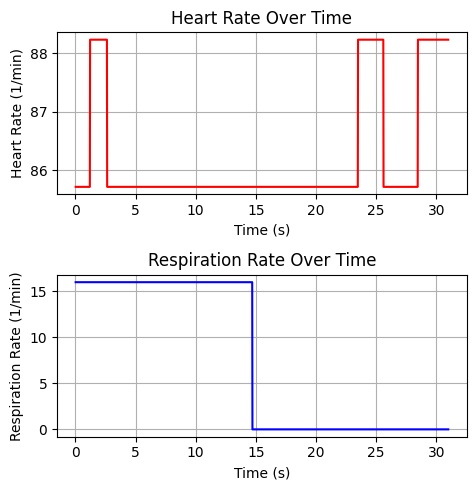

Instruction is older than 2 minutes and will be ignored. Looking for another instruction
Observation fetched at 2024-08-27 20:31:06.919432:
{'resourceType': 'Observation', 'id': '195', 'meta': {'versionId': '1', 'lastUpdated': '2024-08-27T20:30:25.288+00:00', 'source': '#Ysj271JtxQltFqyI'}, 'status': 'final', 'code': {'coding': [{'system': 'http://loinc.org', 'code': '232209000', 'display': '232209000'}], 'text': '232209000'}, 'subject': {'reference': 'Patient/180'}, 'effectiveDateTime': '2024-08-27T22:30:25+02:00', 'valueQuantity': {'value': 0, 'unit': '{s}', 'system': 'http://unitsofmeasure.org', 'code': '{s}'}}
Obstructing patient airway...
Heart Rate value: 85.714286
Respiratory Rate value: 19.867550


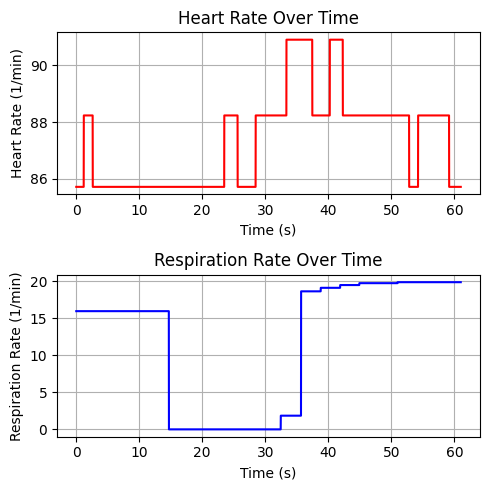

Instruction is older than 2 minutes and will be ignored. Looking for another instruction
Fetching data stopped.
Simulation completed.


In [11]:
import csv
import os
import logging
import requests
import time
from datetime import datetime
import pytz
import ipywidgets as widgets
from IPython.display import display, clear_output
from pulse.engine.PulseEngine import PulseEngine
from pulse.cdm.engine import SEDataRequest, SEDataRequestManager
from pulse.cdm.scalars import FrequencyUnit
from pulse.cdm.patient_actions import SEAirwayObstruction
import configparser
import pandas as pd
import matplotlib.pyplot as plt

def draw():
    csv_file_path = "./simulation_results/UseCase1.csv"
    df = pd.read_csv(csv_file_path)
    fig, axs = plt.subplots(2, 1, figsize=(5, 5))
    
    # Heart Rate plot
    axs[0].plot(df['Time(s)'], df['HeartRate(1/min)'], color='red')
    axs[0].set_title('Heart Rate Over Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Heart Rate (1/min)')
    axs[0].grid(True)
    
    # Respiration Rate plot
    axs[1].plot(df['Time(s)'], df['RespirationRate(1/min)'], color='blue')
    axs[1].set_title('Respiration Rate Over Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Respiration Rate (1/min)')
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
def main():
    patient_id = input("Enter the patient ID: ")
    print("Initial state of the patient:")
    print("------------------------------")
    config_file = ConfigFile()
    data_management = DataManagement(patient_id, config_file)
    simulation_core = SimulationCore(patient_id, data_management)
    look_back = Look_back(patient_id, config_file, simulation_core)

    start_time = time.time()
    try:
        while time.time() - start_time < 300:  # Run the loop for 5 minutes
            instruction = look_back.fetch_instruction("232209000")
            if instruction:
                observation_time = datetime.fromisoformat(instruction['effectiveDateTime'].replace('Z', '+00:00'))
                current_time = datetime.now(pytz.utc)
                # Check if the observation is within the last 1 minute
                if (current_time - observation_time).total_seconds() <= 60:
                    print(f"Observation fetched at {datetime.now()}:")
                    print(instruction)
                    look_back.handle_instruction(instruction)
                    draw()
                else:
                    print(f"Instruction is older than 2 minutes and will be ignored. Looking for another instruction")
            time.sleep(30)
    except KeyboardInterrupt:
        print("Fetching data stopped.")
    finally:
        print("Simulation completed.")
        
# Configuration file handler
class ConfigFile:
    def __init__(self):
        self.config = configparser.ConfigParser()
        self.config.read("config.ini")
    def get_FHIR_server_url(self):
        return self.config['FHIR']['server_url']
    def get_time_zone(self):
        return self.config['TIME_ZONE']['time_zone']
    
# FHIR data fetch and handling class
class Look_back:
    def __init__(self, patient_id, config_file, simulation_core):
        self.patient_id = patient_id
        self.config_file = config_file
        self.simulation_core = simulation_core
        self.FHIR_SERVER_URL = config_file.get_FHIR_server_url()

    # Fetch the latest observation for the patient
    def fetch_instruction(self, code):
        last_processed_observation_id = None
        try:
            observation_url = f"{self.FHIR_SERVER_URL}/Observation?subject=Patient/{self.patient_id }&code={code}&_sort=-date&_count=1"  # Fetch latest

            if last_processed_observation_id:
                observation_url += f"&_id-not={last_processed_observation_id}"

            response = requests.get(observation_url, headers={"Content-Type": "application/fhir+json"})
            if response.status_code == 200:
                observations = response.json().get('entry')
                if observations:
                    last_processed_observation_id = observations[0]['resource']['id']
                    return observations[0]['resource']
                else:
                    print(f"No new observations found for patient {self.patient_id} with code {code}.")
            else:
                print(f"Failed to fetch observation. Status code: {response.status_code}, Reason: {response.text}")
        except Exception as e:
            print(f"An error occurred: {e}")
        return None

    # Handle the fetched observation and obstruct the patient's airway if the observation is an airway obstruction instruction
    def handle_instruction(self, observation):
        codes = [coding['code'] for coding in observation['code']['coding']]
        # Check if the observation is an airway obstruction instruction/adjust airway obstruction level
        if '232209000' in codes:
            if 'valueQuantity' in observation and 'value' in observation['valueQuantity']: # Add the check here.
                obstruction_value = float(observation['valueQuantity']['value'])
                self.simulation_core.obstruct_airway(obstruction_value)

# Data management class for handling FHIR data and CSV file operations
class DataManagement:
    def __init__(self, patient_id, config_file):
        self.FHIR_SERVER_URL = config_file.get_FHIR_server_url()
        self.time_zone = config_file.get_time_zone()
        self.patient_id = patient_id
        self.csv_file_path = "./simulation_results/UseCase1.csv"
        os.makedirs(os.path.dirname(self.csv_file_path), exist_ok=True)

    def _get_result_from_csv(self, csv_file_path):
        last_line = None
        with open(csv_file_path, 'r') as file:
            reader = csv.reader(file)
            for line in reader:
                last_line = line
        return last_line

    def FHIR_data_mapper(self, results):
        timezone = pytz.timezone(self.time_zone)
        timezone_now = datetime.now(timezone)
        read_vital = self._get_result_from_csv(self.csv_file_path)

        if not read_vital:
            print("No data available")
            return

        if read_vital[1] == "HeartRate(1/min)" and read_vital[2] == "RespirationRate(1/min)":
            print("Data is empty but default initialized with")
            read_vital = [0, 85, 18]

        observations = [
            {"loinc_code": "8867-4", "display": "Heart Rate", "value": read_vital[1], "unit": "beats/minute"},
            {"loinc_code": "9279-1", "display": "Respiratory Rate", "value": read_vital[2], "unit": "breaths/minute"}
        ]

        for obs in observations:
            observation_data = {
                "resourceType": "Observation",
                "status": "final",
                "effectiveDateTime": timezone_now.isoformat(),
                "code": {
                    "coding": [{"system": "http://loinc.org", "code": obs['loinc_code'], "display": obs['display']}]
                },
                "subject": {"reference": f"Patient/{self.patient_id}"},
                "valueQuantity": {
                    "value": obs['value'],
                    "unit": obs['unit'],
                    "system": "http://unitsofmeasure.org"
                }
            }
            response = requests.post(f"{self.FHIR_SERVER_URL}/Observation", json=observation_data, headers={"Content-Type": "application/fhir+json"})
            if response.status_code == 201:
                print(f"{obs['display']} value: {obs['value']}")
            else:
                logging.error(f"Failed to add observation {obs['display']}, status code: {response.status_code}, reason: {response.text}")

# Simulation core class for handling PulseEngine and patient state simulations
class SimulationCore:
    def __init__(self, patient_id, data_management):
        self.patient_id = patient_id
        self.pulse = PulseEngine()
        self.data_management = data_management
        self.data_requests = [
            SEDataRequest.create_physiology_request("HeartRate", unit=FrequencyUnit.Per_min),
            SEDataRequest.create_physiology_request("RespirationRate", unit=FrequencyUnit.Per_min),
        ]
        self.data_req_mgr = SEDataRequestManager(self.data_requests)
        self.data_req_mgr.set_results_filename("./simulation_results/UseCase1.csv")
        if not self.pulse.serialize_from_file("./data/states/Soldier@0s.pbb", self.data_req_mgr):
            print("Unable to load initial state file")
        else:
            self.results = self.pulse.pull_data()
        self._advance_time_and_record(1)

    def _advance_time_and_record(self, seconds, action=None):
        if action:
            self.pulse.process_action(action)
        for second in range(1, seconds + 1):
            self.pulse.advance_time_s(1)
            self.results = self.pulse.pull_data()
        self.data_management.FHIR_data_mapper(self.results)
    
    def obstruct_airway(self,value):
        airway_obstruction = SEAirwayObstruction()
        airway_obstruction.set_comment("Patient Airway is obstructed")
        airway_obstruction.get_severity().set_value(value)
        print("Obstructing patient airway...")
        self._advance_time_and_record(30, airway_obstruction)

if __name__ == "__main__":
    main()